<img src="https://github.com/pmservice/ai-openscale-tutorials/raw/master/notebooks/images/banner.png" align="left" alt="banner">

# Working with SageMaker Machine Learning engine

This notebook shows how to log the payload for the model deployed on custom model serving engine using Watson OpenScale python sdk.

Contents
1. [Setup](#setup)
2. [Binding machine learning engine](#binding)
3. [Subscriptions](#subscription)
4. [Performance monitor, scoring and payload logging](#scoring)
5. [Quality monitor and feedback logging](#feedback)
6. [Fairness monitoring and explanations](#fairness)
8. [Payload analytics](#analytics)

<a id="setup"></a>
## 1. Setup

### 1.0 Requirements installation

In [1]:
!pip install --upgrade ibm-ai-openscale --no-cache | tail -n 1

Requirement not upgraded as not directly required: docutils>=0.10 in /opt/conda/envs/DSX-Python35/lib/python3.5/site-packages (from ibm-cos-sdk-core==2.*,>=2.0.0->ibm-cos-sdk->watson-machine-learning-client->ibm-ai-openscale)


In [2]:
!pip install sagemaker --no-cache | tail -n 1
!pip install --upgrade ibm-ai-openscale --no-cache | tail -n 1
!pip install --upgrade boto3 --no-cache | tail -n 1
!pip install --upgrade pandas --no-cache | tail -n 1

Requirement not upgraded as not directly required: pycparser in /opt/conda/envs/DSX-Python35/lib/python3.5/site-packages (from cffi>=1.7->cryptography>=1.5->paramiko>=2.4.2; extra == "ssh"->docker[ssh]<4.0,>=3.7.0->docker-compose>=1.23.0->sagemaker)
Requirement not upgraded as not directly required: jmespath<1.0.0,>=0.7.1 in /opt/conda/envs/DSX-Python35/lib/python3.5/site-packages (from ibm-cos-sdk-core==2.*,>=2.0.0->ibm-cos-sdk->watson-machine-learning-client->ibm-ai-openscale)
Requirement not upgraded as not directly required: six>=1.5 in /opt/conda/envs/DSX-Python35/lib/python3.5/site-packages (from python-dateutil<3.0.0,>=2.1; python_version >= "2.7"->botocore<1.13.0,>=1.12.130->boto3)
Requirement not upgraded as not directly required: six>=1.5 in /opt/conda/envs/DSX-Python35/lib/python3.5/site-packages (from python-dateutil>=2.5.0->pandas)


In [3]:
!pip install pyspark | tail -n 1
!pip install lime | tail -n 1
!pip install pixiedust | tail -n 1

Requirement not upgraded as not directly required: py4j==0.10.7 in /opt/conda/envs/DSX-Python35/lib/python3.5/site-packages (from pyspark)
Requirement not upgraded as not directly required: olefile in /opt/conda/envs/DSX-Python35/lib/python3.5/site-packages (from pillow>=2.1.0->scikit-image>=0.12->lime)
Requirement not upgraded as not directly required: six<2.0,>=1.6.1 in /opt/conda/envs/DSX-Python35/lib/python3.5/site-packages (from astunparse->pixiedust)


**Action:** Restart the kernel.

### 1.1 Sample model creation using [Amazon SageMaker](https://aws.amazon.com/sagemaker/)

- Download this [notebook](https://github.com/pmservice/ai-openscale-tutorials/blob/master/notebooks/Credit%20%20model%20with%20SageMaker%20linear-learner%20.ipynb) to create SageMaker model
- Run the notebook to train a SageMaker model and create deployment endpoint for online inference

### 1.2 Authentication

Import and initiate.

In [4]:
from ibm_ai_openscale import APIClient
from ibm_ai_openscale.supporting_classes import PayloadRecord
from ibm_ai_openscale.supporting_classes.enums import InputDataType, ProblemType
from ibm_ai_openscale.engines import *
from ibm_ai_openscale.utils import *

/opt/conda/envs/DSX-Python35/lib/python3.5/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


#### ACTION: Get OpenScale `instance_guid` and `apikey`

How to install IBM Cloud (bluemix) console: [instruction](https://console.bluemix.net/docs/cli/reference/ibmcloud/download_cli.html#install_use)

How to get api key using bluemix console:
```bash
ibmcloud login --sso
ibmcloud iam api-key-create 'my_key'
```

How to get your OpenScale instance GUID

- if your resource group is different than `default` switch to resource group containing OpenScale instance
```bash
ibmcloud target -g <myResourceGroup>
```
- get details of the instance
```bash
ibmcloud resource service-instance 'AI-OpenScale-instance_name'
```

#### Let's define some constants required to set up data mart:

- AIOS_CREDENTIALS
- POSTGRES_CREDENTIALS
- SCHEMA_NAME

In [5]:
AIOS_CREDENTIALS = {
  "url": "https://api.aiopenscale.cloud.ibm.com",
  "instance_guid": "***",
  "apikey": "***"
}

In [6]:
# The code was removed by Watson Studio for sharing.

In [7]:
POSTGRES_CREDENTIALS = {
    "db_type": "postgresql",
    "uri_cli_1": "xxx",
    "maps": [],
    "instance_administration_api": {
        "instance_id": "xxx",
        "root": "xxx",
        "deployment_id": "xxx"
    },
    "name": "xxx",
    "uri_cli": "xxx",
    "uri_direct_1": "xxx",
    "ca_certificate_base64": "xxx",
    "deployment_id": "xxx",
    "uri": "xxx"
}

In [8]:
# The code was removed by Watson Studio for sharing.

In [9]:
SCHEMA_NAME = 'data_mart_for_aws_sagemaker'

Create schema for data mart.

In [10]:
create_postgres_schema(postgres_credentials=POSTGRES_CREDENTIALS, schema_name=SCHEMA_NAME)

In [11]:
client = APIClient(AIOS_CREDENTIALS)

In [12]:
client.version

'2.1.4'

### 1.3 DataMart setup

In [14]:
client.data_mart.setup(db_credentials=POSTGRES_CREDENTIALS, schema=SCHEMA_NAME)

In [15]:
data_mart_details = client.data_mart.get_details()

<a id="binding"></a>
## 2. Bind machine learning engines

### 2.1 Bind  `SageMaker` machine learning engine

Provide credentials using following fields:
- `access_key_id`
- `secret_access_key`
- `region`

In [16]:
SAGEMAKER_ENGINE_CREDENTIALS = {
        "access_key_id": "***",
        "secret_access_key": "***",
        "region": "***"
}

In [17]:
# The code was removed by Watson Studio for sharing.

In [18]:
binding_uid = client.data_mart.bindings.add('My SageMaker engine', SageMakerMachineLearningInstance(SAGEMAKER_ENGINE_CREDENTIALS))

In [19]:
bindings_details = client.data_mart.bindings.get_details()

In [20]:
client.data_mart.bindings.list()

3f392dbe-8f93-4965-98d2-cf930a0b32cc,My SageMaker engine,amazon_sagemaker,2019-04-08T08:09:19.902Z


<a id="subsciption"></a>
## 3. Subscriptions

### 3.1 Add subscriptions

List available deployments.

**Note:** Depending on number of assets it may take some time.

In [21]:
client.data_mart.bindings.list_assets()

253a3eb8d068b34b9d3e79bffcfcdbb8,Credit-risk-linear-learner-2019-03-29-12-47,2019-03-29T12:54:16.319Z,model,,3f392dbe-8f93-4965-98d2-cf930a0b32cc,False
feccf68ea88cbbb4b09003c31c4ea946,Sklearn-hand-written-digits-1,2019-02-21T05:42:49.304Z,model,,3f392dbe-8f93-4965-98d2-cf930a0b32cc,False
84a9175980d4a0b306c9c79df5086db4,Sklearn-Iris-1,2019-02-21T05:31:43.085Z,model,,3f392dbe-8f93-4965-98d2-cf930a0b32cc,False
56bdbf19ea21a9df15435cc01719051e,Tensorflow-MNIST-1,2019-02-21T05:03:52.351Z,model,,3f392dbe-8f93-4965-98d2-cf930a0b32cc,False
d129c1bddeb1626ae976052587b7fb59,Tensorflow-Iris-2,2019-02-21T04:46:37.062Z,model,,3f392dbe-8f93-4965-98d2-cf930a0b32cc,False
8c23f3df9ec0016fe39694c2b116e25d,Credit-risk-linear-learner-2019-02-14-15-20,2019-02-14T15:24:31.653Z,model,,3f392dbe-8f93-4965-98d2-cf930a0b32cc,False
57d1b9ccf254e8f05fdcb0ac05744e94,Credit-risk-linear-learner-2019-02-14-14-05,2019-02-14T14:11:25.761Z,model,,3f392dbe-8f93-4965-98d2-cf930a0b32cc,False
e23cada2cc488830e5dfc26172bdf58d,Credit-risk-linear-learner-2019-02-14-13-28,2019-02-14T13:37:28.847Z,model,,3f392dbe-8f93-4965-98d2-cf930a0b32cc,False
d38ee50a0044287128baed4999310045,Credit-risk-xgboost-2019-02-04-11-01,2019-02-04T11:06:44.414Z,model,,3f392dbe-8f93-4965-98d2-cf930a0b32cc,False
f2f0634d275a1fa8e2fbf83aec3f67d1,linear-learner-2019-01-30-09-29-48-997,2019-01-30T09:29:49.165Z,model,,3f392dbe-8f93-4965-98d2-cf930a0b32cc,False
d21922c42afc955283658215a7c3b456,Credit-risk-linear-learner-2019-01-10-14-54,2019-01-10T14:58:53.836Z,model,,3f392dbe-8f93-4965-98d2-cf930a0b32cc,False


**Action:** Assign your source_uid to `source_uid` variable below.

In [22]:
source_uid = '253a3eb8d068b34b9d3e79bffcfcdbb8'

In [23]:
feature_columns = ['CheckingStatus_0_to_200', 'CheckingStatus_greater_200', 'CheckingStatus_less_0', 'CheckingStatus_no_checking', 'CreditHistory_all_credits_paid_back', 'CreditHistory_credits_paid_to_date', 'CreditHistory_no_credits', 'CreditHistory_outstanding_credit', 'CreditHistory_prior_payments_delayed', 'LoanPurpose_appliances', 'LoanPurpose_business', 'LoanPurpose_car_new', 'LoanPurpose_car_used', 'LoanPurpose_education', 'LoanPurpose_furniture', 'LoanPurpose_other', 'LoanPurpose_radio_tv', 'LoanPurpose_repairs', 'LoanPurpose_retraining', 'LoanPurpose_vacation', 'ExistingSavings_100_to_500', 'ExistingSavings_500_to_1000', 'ExistingSavings_greater_1000', 'ExistingSavings_less_100', 'ExistingSavings_unknown', 'EmploymentDuration_1_to_4', 'EmploymentDuration_4_to_7', 'EmploymentDuration_greater_7', 'EmploymentDuration_less_1', 'EmploymentDuration_unemployed', 'Sex_female', 'Sex_male', 'OthersOnLoan_co-applicant', 'OthersOnLoan_guarantor', 'OthersOnLoan_none', 'OwnsProperty_car_other', 'OwnsProperty_real_estate', 'OwnsProperty_savings_insurance', 'OwnsProperty_unknown', 'InstallmentPlans_bank', 'InstallmentPlans_none', 'InstallmentPlans_stores', 'Housing_free', 'Housing_own', 'Housing_rent', 'Job_management_self-employed', 'Job_skilled', 'Job_unemployed', 'Job_unskilled', 'Telephone_none', 'Telephone_yes', 'ForeignWorker_no', 'ForeignWorker_yes', 'LoanDuration', 'LoanAmount', 'InstallmentPercent', 'CurrentResidenceDuration', 'Age', 'ExistingCreditsCount', 'Dependents']
categorical_columns = ['CheckingStatus_0_to_200', 'CheckingStatus_greater_200', 'CheckingStatus_less_0', 'CheckingStatus_no_checking', 'CreditHistory_all_credits_paid_back', 'CreditHistory_credits_paid_to_date', 'CreditHistory_no_credits', 'CreditHistory_outstanding_credit', 'CreditHistory_prior_payments_delayed', 'LoanPurpose_appliances', 'LoanPurpose_business', 'LoanPurpose_car_new', 'LoanPurpose_car_used', 'LoanPurpose_education', 'LoanPurpose_furniture', 'LoanPurpose_other', 'LoanPurpose_radio_tv', 'LoanPurpose_repairs', 'LoanPurpose_retraining', 'LoanPurpose_vacation', 'ExistingSavings_100_to_500', 'ExistingSavings_500_to_1000', 'ExistingSavings_greater_1000', 'ExistingSavings_less_100', 'ExistingSavings_unknown', 'EmploymentDuration_1_to_4', 'EmploymentDuration_4_to_7', 'EmploymentDuration_greater_7', 'EmploymentDuration_less_1', 'EmploymentDuration_unemployed', 'Sex_female', 'Sex_male', 'OthersOnLoan_co-applicant', 'OthersOnLoan_guarantor', 'OthersOnLoan_none', 'OwnsProperty_car_other', 'OwnsProperty_real_estate', 'OwnsProperty_savings_insurance', 'OwnsProperty_unknown', 'InstallmentPlans_bank', 'InstallmentPlans_none', 'InstallmentPlans_stores', 'Housing_free', 'Housing_own', 'Housing_rent', 'Job_management_self-employed', 'Job_skilled', 'Job_unemployed', 'Job_unskilled', 'Telephone_none', 'Telephone_yes', 'ForeignWorker_no', 'ForeignWorker_yes']

In [25]:
subscription = client.data_mart.subscriptions.add(
    SageMakerMachineLearningAsset(
                source_uid=source_uid,
                binding_uid=binding_uid,
                input_data_type=InputDataType.STRUCTURED,
                problem_type=ProblemType.BINARY_CLASSIFICATION,
                label_column='Risk',
                feature_columns=feature_columns.copy(),
                categorical_columns=categorical_columns.copy(),
                probability_column='score',
                prediction_column='predicted_label'))

#### List subscriptions

In [26]:
client.data_mart.subscriptions.list()

253a3eb8d068b34b9d3e79bffcfcdbb8,Credit-risk-linear-learner-2019-03-29-12-47,model,3f392dbe-8f93-4965-98d2-cf930a0b32cc,2019-04-08T08:21:14.661Z


<a id="scoring"></a>
## 4. Performance metrics, scoring and payload logging

### 4.1 Score the credit risk model and measure response time

In [27]:
import requests
import time
import json
import boto3

In [28]:
subscription_details = subscription.get_details()
endpoint_name = subscription_details['entity']['deployments'][0]['name']

In [29]:
binding_details = client.data_mart.bindings.get_details(binding_uid=binding_uid)
access_id = binding_details['entity']['credentials']['access_key_id']
access_key = binding_details['entity']['credentials']['secret_access_key']
region = binding_details['entity']['credentials']['region']

subscription_details = subscription.get_details()
endpoint_name = subscription_details['entity']['deployments'][0]['name']

payload = "0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,12,4152,2,3,29,2,1"

In [30]:
runtime = boto3.client('sagemaker-runtime', region_name=region, aws_access_key_id=access_id, aws_secret_access_key=access_key)

start_time = time.time()
response = runtime.invoke_endpoint(EndpointName=endpoint_name, ContentType='text/csv', Body=payload)
response_time = int((time.time() - start_time)*1000)
result = json.loads(response['Body'].read().decode())

print(json.dumps(result, indent=2))

{
  "predictions": [
    {
      "predicted_label": 0.0,
      "score": 0.20244570076465607
    }
  ]
}


### 4.2 Store the request and response in payload logging table

#### Transform the model's input and output to the format compatible with OpenScale standard.

In [31]:
values = [float(s) for s in payload.split(',')]

request_data = {'fields': feature_columns, 
                'values': values}

response_data = {'fields': list(result['predictions'][0]),
                 'values': [list(x.values()) for x in result['predictions']]}

#### Store the payload using Python SDK

**Hint:** You can embed payload logging code into your custom deployment so it is logged automatically each time you score the model.

In [35]:
records_list = []

for i in range(0, 10):
    records_list.append(PayloadRecord(request=request_data, response=response_data, response_time=response_time))

subscription.payload_logging.store(records=records_list)

In [38]:
import time

time.sleep(3)
subscription.payload_logging.show_table(limit=3)

ea3cd968-c127-42fc-9ee4-2205d6788659-1,2019-04-08 08:22:55.470000+00:00,a3e4abd3429870983b100b4b609d469a,None,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,12.0,4152.0,2.0,3.0,29.0,2.0,1.0,0.0,0.20244570076465607,0.7975542992353439,None,None
28a7fee5-4856-4de0-a6ca-678b7557e911-1,2019-04-08 08:22:55.469000+00:00,a3e4abd3429870983b100b4b609d469a,None,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,12.0,4152.0,2.0,3.0,29.0,2.0,1.0,0.0,0.20244570076465607,0.7975542992353439,None,None
3f618053-0224-4d1a-a9b9-c32e97ac4b4c-1,2019-04-08 08:22:55.469000+00:00,a3e4abd3429870983b100b4b609d469a,None,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,12.0,4152.0,2.0,3.0,29.0,2.0,1.0,0.0,0.20244570076465607,0.7975542992353439,None,None


In [39]:
subscription.payload_logging.get_details()

{'enabled': True,
 'parameters': {'dynamic_schema_update': True,
  'output_data_schema': {'fields': [{'metadata': {'measure': 'discrete',
      'modeling_role': 'feature'},
     'name': 'CheckingStatus_0_to_200',
     'nullable': True,
     'type': 'double'},
    {'metadata': {'measure': 'discrete', 'modeling_role': 'feature'},
     'name': 'CheckingStatus_greater_200',
     'nullable': True,
     'type': 'double'},
    {'metadata': {'measure': 'discrete', 'modeling_role': 'feature'},
     'name': 'CheckingStatus_less_0',
     'nullable': True,
     'type': 'double'},
    {'metadata': {'measure': 'discrete', 'modeling_role': 'feature'},
     'name': 'CheckingStatus_no_checking',
     'nullable': True,
     'type': 'double'},
    {'metadata': {'measure': 'discrete', 'modeling_role': 'feature'},
     'name': 'CreditHistory_all_credits_paid_back',
     'nullable': True,
     'type': 'double'},
    {'metadata': {'measure': 'discrete', 'modeling_role': 'feature'},
     'name': 'CreditHistor

#### Store the payload using REST API

Get the token first.

In [40]:
token_endpoint = "https://iam.bluemix.net/identity/token"
headers = {
    "Content-Type": "application/x-www-form-urlencoded",
    "Accept": "application/json"
}

data = {
    "grant_type": "urn:ibm:params:oauth:grant-type:apikey",
    "apikey": AIOS_CREDENTIALS["apikey"]
}

req = requests.post(token_endpoint, data=data, headers=headers)
token = req.json()['access_token']

Store the payload.

In [41]:
import requests, uuid

PAYLOAD_STORING_HREF_PATTERN = '{}/v1/data_marts/{}/scoring_payloads'
endpoint = PAYLOAD_STORING_HREF_PATTERN.format(AIOS_CREDENTIALS['url'], AIOS_CREDENTIALS['data_mart_id'])

payload = [{
    'binding_id': binding_uid, 
    'deployment_id': subscription.get_details()['entity']['deployments'][0]['deployment_id'], 
    'subscription_id': subscription.uid, 
    'scoring_id': str(uuid.uuid4()), 
    'response': response_data,
    'request': request_data
}]

headers = {"Authorization": "Bearer " + token}
      
req_response = requests.post(endpoint, json=payload, headers = headers)

print("Request OK: " + str(req_response.ok))

Request OK: True


### Performance metrics of scoring requests

In [42]:
subscription.performance_monitoring.show_table(limit=10)

2019-04-08 08:21:38.369000+00:00,337.0,1,3f392dbe-8f93-4965-98d2-cf930a0b32cc,253a3eb8d068b34b9d3e79bffcfcdbb8,a3e4abd3429870983b100b4b609d469a,,
2019-04-08 08:22:55.469000+00:00,337.0,1,3f392dbe-8f93-4965-98d2-cf930a0b32cc,253a3eb8d068b34b9d3e79bffcfcdbb8,a3e4abd3429870983b100b4b609d469a,,
2019-04-08 08:22:55.469000+00:00,337.0,1,3f392dbe-8f93-4965-98d2-cf930a0b32cc,253a3eb8d068b34b9d3e79bffcfcdbb8,a3e4abd3429870983b100b4b609d469a,,
2019-04-08 08:22:55.469000+00:00,337.0,1,3f392dbe-8f93-4965-98d2-cf930a0b32cc,253a3eb8d068b34b9d3e79bffcfcdbb8,a3e4abd3429870983b100b4b609d469a,,
2019-04-08 08:22:55.469000+00:00,337.0,1,3f392dbe-8f93-4965-98d2-cf930a0b32cc,253a3eb8d068b34b9d3e79bffcfcdbb8,a3e4abd3429870983b100b4b609d469a,,
2019-04-08 08:22:55.469000+00:00,337.0,1,3f392dbe-8f93-4965-98d2-cf930a0b32cc,253a3eb8d068b34b9d3e79bffcfcdbb8,a3e4abd3429870983b100b4b609d469a,,
2019-04-08 08:22:55.469000+00:00,337.0,1,3f392dbe-8f93-4965-98d2-cf930a0b32cc,253a3eb8d068b34b9d3e79bffcfcdbb8,a3e4abd3429870983b100b4b609d469a,,
2019-04-08 08:22:55.470000+00:00,337.0,1,3f392dbe-8f93-4965-98d2-cf930a0b32cc,253a3eb8d068b34b9d3e79bffcfcdbb8,a3e4abd3429870983b100b4b609d469a,,
2019-04-08 08:22:55.469000+00:00,337.0,1,3f392dbe-8f93-4965-98d2-cf930a0b32cc,253a3eb8d068b34b9d3e79bffcfcdbb8,a3e4abd3429870983b100b4b609d469a,,
2019-04-08 08:22:55.469000+00:00,337.0,1,3f392dbe-8f93-4965-98d2-cf930a0b32cc,253a3eb8d068b34b9d3e79bffcfcdbb8,a3e4abd3429870983b100b4b609d469a,,


<a id="feedback"></a>
## 5. Feedback logging & quality (accuracy) monitoring

### Enable quality monitoring

You need to provide the monitoring `threshold` and `min_records` (minimal number of feedback records).

In [43]:
subscription.quality_monitoring.enable(threshold=0.7, min_records=5)

### Feedback records logging

Feedback records are used to evaluate your model. The predicted values are compared to real values (feedback records).

You can check the schema of feedback table using below method.

In [44]:
subscription.feedback_logging.print_table_schema()

CheckingStatus_0_to_200,double,True
CheckingStatus_greater_200,double,True
CheckingStatus_less_0,double,True
CheckingStatus_no_checking,double,True
CreditHistory_all_credits_paid_back,double,True
CreditHistory_credits_paid_to_date,double,True
CreditHistory_no_credits,double,True
CreditHistory_outstanding_credit,double,True
CreditHistory_prior_payments_delayed,double,True
LoanPurpose_appliances,double,True
LoanPurpose_business,double,True


The feedback records can be send to feedback table using below code.

In [45]:
feedback_records = []

for i in range(1, 10):
    feedback_records.append("0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,31,1889,3,3,32,1,1")

subscription.feedback_logging.store(feedback_data='\n'.join(feedback_records), fields=['Risk'] + feature_columns, feedback_format='text')

### Run quality monitoring on demand

By default, quality monitoring is run on hourly schedule. You can also trigger it on demand using below code.

In [46]:
run_details = subscription.quality_monitoring.run(background_mode=True)

Since the monitoring runs in the background you can use below method to check the status of the job.

In [47]:
status = run_details['status']
run_id = run_details['id']

print("Run status: {}".format(status))

start_time = time.time()
elapsed_time = 0

while status != 'completed' and elapsed_time < 60:
    time.sleep(10)
    run_details = subscription.quality_monitoring.get_run_details(run_uid=run_id)
    status = run_details['status']
    elapsed_time = time.time() - start_time
    print("Run status: {}".format(status))

Run status: initializing
Run status: completed


### Show the quality metrics

In [48]:
subscription.quality_monitoring.show_table()

2019-04-08 08:25:20.518000+00:00,area_under_roc,0.0,0.7,,,3f392dbe-8f93-4965-98d2-cf930a0b32cc,253a3eb8d068b34b9d3e79bffcfcdbb8,a3e4abd3429870983b100b4b609d469a
2019-04-08 08:25:20.518000+00:00,accuracy,0.0,,,,3f392dbe-8f93-4965-98d2-cf930a0b32cc,253a3eb8d068b34b9d3e79bffcfcdbb8,a3e4abd3429870983b100b4b609d469a
2019-04-08 08:25:20.518000+00:00,area_under_pr,0.0,,,,3f392dbe-8f93-4965-98d2-cf930a0b32cc,253a3eb8d068b34b9d3e79bffcfcdbb8,a3e4abd3429870983b100b4b609d469a


Get all calculated metrics.

In [49]:
[deployment_uid, *_] = subscription.get_deployment_uids()

In [50]:
subscription.quality_monitoring.get_metrics(deployment_uid=deployment_uid)

[{'binding_id': '3f392dbe-8f93-4965-98d2-cf930a0b32cc',
  'metrics': [{'id': 'area_under_roc', 'lower_limit': 0.7, 'value': 0.0},
   {'id': 'accuracy', 'value': 0.0},
   {'id': 'area_under_pr', 'value': 0.0}],
  'monitor_definition_id': 'quality',
  'subscription_id': '253a3eb8d068b34b9d3e79bffcfcdbb8',
  'tags': [],
  'ts': '2019-04-08T08:25:20.518Z'}]

<a id="datamart"></a>
## 6. Get the logged data

### 6.1 Payload logging

#### Print schema of payload_logging table

In [51]:
subscription.payload_logging.print_table_schema()

scoring_id,string,False
scoring_timestamp,timestamp,False
deployment_id,string,False
asset_revision,string,True
CheckingStatus_0_to_200,double,True
CheckingStatus_greater_200,double,True
CheckingStatus_less_0,double,True
CheckingStatus_no_checking,double,True
CreditHistory_all_credits_paid_back,double,True
CreditHistory_credits_paid_to_date,double,True
CreditHistory_no_credits,double,True


#### Show (preview) the table

In [52]:
subscription.payload_logging.describe_table()

       CheckingStatus_0_to_200  CheckingStatus_greater_200  \
count                     12.0                        12.0   
mean                       0.0                         0.0   
std                        0.0                         0.0   
min                        0.0                         0.0   
25%                        0.0                         0.0   
50%                        0.0                         0.0   
75%                        0.0                         0.0   
max                        0.0                         0.0   

       CheckingStatus_less_0  CheckingStatus_no_checking  \
count                   12.0                        12.0   
mean                     1.0                         0.0   
std                      0.0                         0.0   
min                      1.0                         0.0   
25%                      1.0                         0.0   
50%                      1.0                         0.0   
75%                  

#### Return the table content as pandas dataframe

In [53]:
pandas_df = subscription.payload_logging.get_table_content(format='pandas')

In [54]:
pandas_df

,scoring_id,scoring_timestamp,deployment_id,asset_revision,CheckingStatus_0_to_200,CheckingStatus_greater_200,CheckingStatus_less_0,CheckingStatus_no_checking,CreditHistory_all_credits_paid_back,CreditHistory_credits_paid_to_date,...,InstallmentPercent,CurrentResidenceDuration,Age,ExistingCreditsCount,Dependents,predicted_label,score,prediction_probability,debiased_prediction,debiased_probability
0,0fe55f83-e3e0-4015-a721-11aeb2e940af-1,2019-04-08 08:24:31.353000+00:00,a3e4abd3429870983b100b4b609d469a,None,0.0,0.0,1.0,0.0,1.0,0.0,...,2.0,3.0,29.0,2.0,1.0,0.0,0.202446,0.797554,None,None
1,ea3cd968-c127-42fc-9ee4-2205d6788659-1,2019-04-08 08:22:55.470000+00:00,a3e4abd3429870983b100b4b609d469a,None,0.0,0.0,1.0,0.0,1.0,0.0,...,2.0,3.0,29.0,2.0,1.0,0.0,0.202446,0.797554,None,None
2,28a7fee5-4856-4de0-a6ca-678b7557e911-1,2019-04-08 08:22:55.469000+00:00,a3e4abd3429870983b100b4b609d469a,None,0.0,0.0,1.0,0.0,1.0,0.0,...,2.0,3.0,29.0,2.0,1.0,0.0,0.202446,0.797554,None,None
3,3f618053-0224-4d1a-a9b9-c32e97ac4b4c-1,2019-04-08 08:22:55.469000+00:00,a3e4abd3429870983b100b4b609d469a,None,0.0,0.0,1.0,0.0,1.0,0.0,...,2.0,3.0,29.0,2.0,1.0,0.0,0.202446,0.797554,None,None
4,41c946c6-f4d8-47da-b5ec-218194fcd8d3-1,2019-04-08 08:22:55.469000+00:00,a3e4abd3429870983b100b4b609d469a,None,0.0,0.0,1.0,0.0,1.0,0.0,...,2.0,3.0,29.0,2.0,1.0,0.0,0.202446,0.797554,None,None
5,5f7349a6-da12-431e-9c6d-fd7d0425a0e0-1,2019-04-08 08:22:55.469000+00:00,a3e4abd3429870983b100b4b609d469a,None,0.0,0.0,1.0,0.0,1.0,0.0,...,2.0,3.0,29.0,2.0,1.0,0.0,0.202446,0.797554,None,None
6,6fcbd34a-9d71-4504-a53d-d2185500f591-1,2019-04-08 08:22:55.469000+00:00,a3e4abd3429870983b100b4b609d469a,None,0.0,0.0,1.0,0.0,1.0,0.0,...,2.0,3.0,29.0,2.0,1.0,0.0,0.202446,0.797554,None,None
7,c96977d6-54e2-46d0-9bdd-331db40844ad-1,2019-04-08 08:22:55.469000+00:00,a3e4abd3429870983b100b4b609d469a,None,0.0,0.0,1.0,0.0,1.0,0.0,...,2.0,3.0,29.0,2.0,1.0,0.0,0.202446,0.797554,None,None
8,d719cb45-f09b-448b-b982-e04cddcf5e9b-1,2019-04-08 08:22:55.469000+00:00,a3e4abd3429870983b100b4b609d469a,None,0.0,0.0,1.0,0.0,1.0,0.0,...,2.0,3.0,29.0,2.0,1.0,0.0,0.202446,0.797554,None,None
9,f8e2432c-413d-4c34-abeb-befe80ec8e86-1,2019-04-08 08:22:55.469000+00:00,a3e4abd3429870983b100b4b609d469a,None,0.0,0.0,1.0,0.0,1.0,0.0,...,2.0,3.0,29.0,2.0,1.0,0.0,0.202446,0.797554,None,None


### 6.2 Feddback logging

Check the schema of table.

In [55]:
subscription.feedback_logging.print_table_schema()

CheckingStatus_0_to_200,double,True
CheckingStatus_greater_200,double,True
CheckingStatus_less_0,double,True
CheckingStatus_no_checking,double,True
CreditHistory_all_credits_paid_back,double,True
CreditHistory_credits_paid_to_date,double,True
CreditHistory_no_credits,double,True
CreditHistory_outstanding_credit,double,True
CreditHistory_prior_payments_delayed,double,True
LoanPurpose_appliances,double,True
LoanPurpose_business,double,True


Preview table content.

In [56]:
subscription.feedback_logging.show_table()

0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,31.0,1889.0,3.0,3.0,32.0,1.0,1.0,2019-04-08 08:25:13.839000+00:00
0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,31.0,1889.0,3.0,3.0,32.0,1.0,1.0,2019-04-08 08:25:13.839000+00:00
0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,31.0,1889.0,3.0,3.0,32.0,1.0,1.0,2019-04-08 08:25:13.839000+00:00
0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,31.0,1889.0,3.0,3.0,32.0,1.0,1.0,2019-04-08 08:25:13.839000+00:00
0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,31.0,1889.0,3.0,3.0,32.0,1.0,1.0,2019-04-08 08:25:13.839000+00:00
0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,31.0,1889.0,3.0,3.0,32.0,1.0,1.0,2019-04-08 08:25:13.839000+00:00
0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,31.0,1889.0,3.0,3.0,32.0,1.0,1.0,2019-04-08 08:25:13.839000+00:00
0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,31.0,1889.0,3.0,3.0,32.0,1.0,1.0,2019-04-08 08:25:13.839000+00:00
0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,31.0,1889.0,3.0,3.0,32.0,1.0,1.0,2019-04-08 08:25:13.839000+00:00


Describe table (calulcate basic statistics).

In [57]:
subscription.feedback_logging.describe_table()

       CheckingStatus_0_to_200  CheckingStatus_greater_200  \
count                      9.0                         9.0   
mean                       0.0                         1.0   
std                        0.0                         0.0   
min                        0.0                         1.0   
25%                        0.0                         1.0   
50%                        0.0                         1.0   
75%                        0.0                         1.0   
max                        0.0                         1.0   

       CheckingStatus_less_0  CheckingStatus_no_checking  \
count                    9.0                         9.0   
mean                     0.0                         0.0   
std                      0.0                         0.0   
min                      0.0                         0.0   
25%                      0.0                         0.0   
50%                      0.0                         0.0   
75%                  

Get table content.

In [58]:
feedback_pd = subscription.feedback_logging.get_table_content(format='pandas')
print(feedback_pd.shape)

(9, 62)


### 6.3 Quality metrics table

In [59]:
subscription.quality_monitoring.print_table_schema()

ts,timestamp,False
id,float,False
value,float,False
lower limit,float,False
upper limit,float,False
tags,string,False
binding_id,string,False
subscription_id,string,False
deployment_id,string,True


In [60]:
subscription.quality_monitoring.show_table()

2019-04-08 08:25:20.518000+00:00,area_under_roc,0.0,0.7,,,3f392dbe-8f93-4965-98d2-cf930a0b32cc,253a3eb8d068b34b9d3e79bffcfcdbb8,a3e4abd3429870983b100b4b609d469a
2019-04-08 08:25:20.518000+00:00,accuracy,0.0,,,,3f392dbe-8f93-4965-98d2-cf930a0b32cc,253a3eb8d068b34b9d3e79bffcfcdbb8,a3e4abd3429870983b100b4b609d469a
2019-04-08 08:25:20.518000+00:00,area_under_pr,0.0,,,,3f392dbe-8f93-4965-98d2-cf930a0b32cc,253a3eb8d068b34b9d3e79bffcfcdbb8,a3e4abd3429870983b100b4b609d469a


### 6.4 Performance metrics table

In [61]:
subscription.performance_monitoring.print_table_schema()

ts,timestamp,False
scoring_time,float,False
scoring_records,object,False
binding_id,string,False
subscription_id,string,False
deployment_id,string,True
process,string,False
asset_revision,string,True


In [62]:
subscription.performance_monitoring.show_table()

2019-04-08 08:21:38.369000+00:00,337.0,1,3f392dbe-8f93-4965-98d2-cf930a0b32cc,253a3eb8d068b34b9d3e79bffcfcdbb8,a3e4abd3429870983b100b4b609d469a,,
2019-04-08 08:22:55.469000+00:00,337.0,1,3f392dbe-8f93-4965-98d2-cf930a0b32cc,253a3eb8d068b34b9d3e79bffcfcdbb8,a3e4abd3429870983b100b4b609d469a,,
2019-04-08 08:22:55.469000+00:00,337.0,1,3f392dbe-8f93-4965-98d2-cf930a0b32cc,253a3eb8d068b34b9d3e79bffcfcdbb8,a3e4abd3429870983b100b4b609d469a,,
2019-04-08 08:22:55.469000+00:00,337.0,1,3f392dbe-8f93-4965-98d2-cf930a0b32cc,253a3eb8d068b34b9d3e79bffcfcdbb8,a3e4abd3429870983b100b4b609d469a,,
2019-04-08 08:22:55.469000+00:00,337.0,1,3f392dbe-8f93-4965-98d2-cf930a0b32cc,253a3eb8d068b34b9d3e79bffcfcdbb8,a3e4abd3429870983b100b4b609d469a,,
2019-04-08 08:22:55.469000+00:00,337.0,1,3f392dbe-8f93-4965-98d2-cf930a0b32cc,253a3eb8d068b34b9d3e79bffcfcdbb8,a3e4abd3429870983b100b4b609d469a,,
2019-04-08 08:22:55.469000+00:00,337.0,1,3f392dbe-8f93-4965-98d2-cf930a0b32cc,253a3eb8d068b34b9d3e79bffcfcdbb8,a3e4abd3429870983b100b4b609d469a,,
2019-04-08 08:22:55.470000+00:00,337.0,1,3f392dbe-8f93-4965-98d2-cf930a0b32cc,253a3eb8d068b34b9d3e79bffcfcdbb8,a3e4abd3429870983b100b4b609d469a,,
2019-04-08 08:22:55.469000+00:00,337.0,1,3f392dbe-8f93-4965-98d2-cf930a0b32cc,253a3eb8d068b34b9d3e79bffcfcdbb8,a3e4abd3429870983b100b4b609d469a,,
2019-04-08 08:22:55.469000+00:00,337.0,1,3f392dbe-8f93-4965-98d2-cf930a0b32cc,253a3eb8d068b34b9d3e79bffcfcdbb8,a3e4abd3429870983b100b4b609d469a,,


### 6.5 Data Mart measurement facts table

In [63]:
client.data_mart.get_deployment_metrics()

{'deployment_metrics': [{'asset': {'asset_id': '253a3eb8d068b34b9d3e79bffcfcdbb8',
    'asset_type': 'model',
    'created_at': '2019-03-29T12:54:16.319Z',
    'name': 'Credit-risk-linear-learner-2019-03-29-12-47',
    'url': 's3://sagemaker-us-east-1-rbigaj-20190329-testfest/credit-risk/output/Credit-risk-linear-learner-2019-03-29-12-47/output/model.tar.gz'},
   'deployment': {'created_at': '2019-03-29T12:57:53.392Z',
    'deployment_id': 'a3e4abd3429870983b100b4b609d469a',
    'deployment_rn': 'arn:aws:sagemaker:us-east-1:014862798213:endpoint/rb-credit-risk-endpoint-scoring-2019-03-29-12-47',
    'deployment_type': 'online',
    'name': 'RB-Credit-risk-endpoint-scoring-2019-03-29-12-47',
    'scoring_endpoint': {'request_headers': {'Content-Type': 'application/json'},
     'url': 'RB-Credit-risk-endpoint-scoring-2019-03-29-12-47'},
    'url': 'RB-Credit-risk-endpoint-scoring-2019-03-29-12-47'},
   'metrics': [{'issues': 0,
     'metric_type': 'performance',
     'timestamp': '2019-0

<a id="fairness_and_explainability"></a>
## 7. Fairness monitoring and explanations

### Get training data

In [64]:
import numpy as np
import pandas as pd

training_data_pd = pd.read_csv(filepath_or_buffer="https://raw.githubusercontent.com/pmservice/ai-openscale-tutorials/master/notebooks/data/credit_risk_training_recoded.csv",
                               header=0,
                               dtype=np.int64)

### Enable and run fairness monitoring

In [65]:
from ibm_ai_openscale.supporting_classes.feature import Feature

subscription.fairness_monitoring.enable(
            training_data=training_data_pd,
            features=[
                Feature("Sex_female", majority=[[0,0]], minority=[[1,1]], threshold=0.95),
                Feature("Age", majority=[[26, 75]], minority=[[18, 25]], threshold=0.95)
            ],
            favourable_classes=[0],
            unfavourable_classes=[1],
            min_records=5
        )

### Run fairness monitor

In [66]:
run_details = subscription.fairness_monitoring.run(background_mode=False)




 Counting bias for deployment_uid=a3e4abd3429870983b100b4b609d469a 




RUNNING.
FINISHED

---------------------------
 Successfully finished run 
---------------------------




In [67]:
subscription.fairness_monitoring.show_table()

2019-04-08 08:27:38.060745+00:00,Sex_female,"[1, 1]",False,1.0,100.0,3f392dbe-8f93-4965-98d2-cf930a0b32cc,253a3eb8d068b34b9d3e79bffcfcdbb8,253a3eb8d068b34b9d3e79bffcfcdbb8,a3e4abd3429870983b100b4b609d469a,
2019-04-08 08:27:38.060745+00:00,Age,"[18, 25]",False,1.0,100.0,3f392dbe-8f93-4965-98d2-cf930a0b32cc,253a3eb8d068b34b9d3e79bffcfcdbb8,253a3eb8d068b34b9d3e79bffcfcdbb8,a3e4abd3429870983b100b4b609d469a,


### Enable Explainability and run explanation on sample record

In [68]:
subscription.explainability.enable(training_data=training_data_pd)

Getting a `transaction_id` to run explanation on

In [69]:
[transaction_id, *_] = subscription.payload_logging.get_table_content().scoring_id
print(transaction_id)

0fe55f83-e3e0-4015-a721-11aeb2e940af-1


In [73]:
explain_run = subscription.explainability.run(transaction_id, background_mode=False)

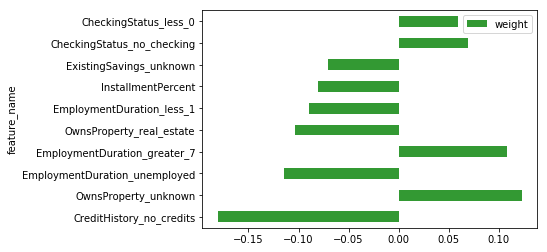

In [75]:
%matplotlib inline

explain_result = pd.DataFrame.from_dict(explain_run['entity']['predictions'][0]['explanation_features'])
explain_result.plot.barh(x='feature_name', y='weight', color='g', alpha=0.8);

---

### Authors
Wojciech Sobala, is a Data Scientist at IBM with a track record of developing enterprise-level applications that substantially increases clients' ability to turn data into actionable knowledge.